# Illustration of audio transforms

[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/mindspore/blob/master/docs/api/api_python_en/samples/dataset/audio_gallery.ipynb)

This example illustrates the various transforms available in the [mindspore.dataset.audio](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.transforms.html#module-mindspore.dataset.audio) module.


## Preparation


In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import scipy.signal as signal
from IPython.display import Audio
from download import download

import mindspore.dataset as ds
import mindspore.dataset.audio as audio

ds.config.set_seed(5)

# cication: LibriSpeech http://www.openslr.org/12
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/84-121123-0000.wav"
download(url, './84-121123-0000.wav', replace=True)
wav_file = "84-121123-0000.wav"

def plot_waveform(waveform, sr, title="Waveform"):
    if waveform.ndim == 1:
        waveform = waveform[np.newaxis, :]
    num_channels, num_frames = waveform.shape
    time_axis = np.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    _, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)



file_sizes: 100%|██████████████████████████| 67.0k/67.0k [00:01<00:00, 47.6kB/s]
Successfully downloaded file to ./84-121123-0000.wav


## Original Waveform


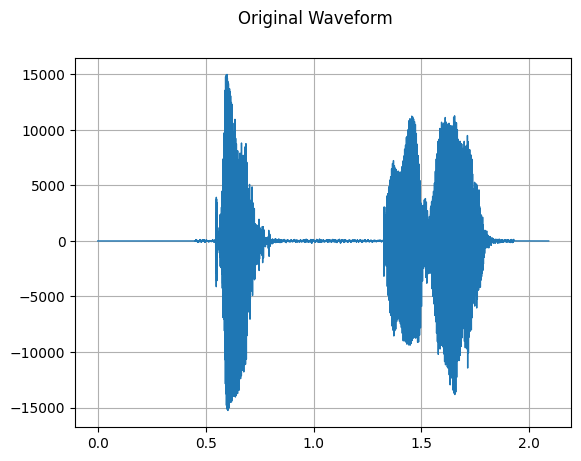

In [2]:
sample_rate, waveform = wavfile.read(wav_file)
plot_waveform(waveform, sample_rate, title="Original Waveform")
Audio(waveform, rate=sample_rate)

## AmplitudeToDB

[mindspore.dataset.audio.AmplitudeToDB](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.AmplitudeToDB.html#mindspore.dataset.audio.AmplitudeToDB) converts audio data from amplitude units to decibel units.


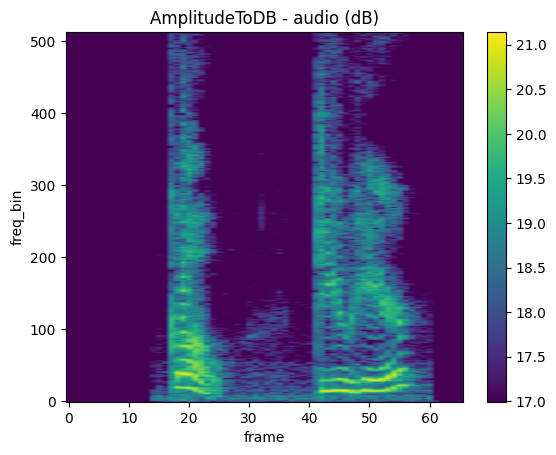

In [3]:
waveform = waveform.astype(np.float32)
n_fft = 1024
hop_length = 512
spectrogram = audio.Spectrogram(n_fft=n_fft, hop_length=hop_length)
specgram = spectrogram(waveform)
amplitude_to_db = audio.AmplitudeToDB(stype=audio.ScaleType.POWER)
db_specgram = amplitude_to_db(specgram)
plot_spectrogram(db_specgram, title="AmplitudeToDB - audio (dB)")

## DBToAmplitude

[mindspore.dataset.audio.DBToAmplitude](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.DBToAmplitude.html#mindspore.dataset.audio.DBToAmplitude) converts audio data from decibel units to amplitude units.


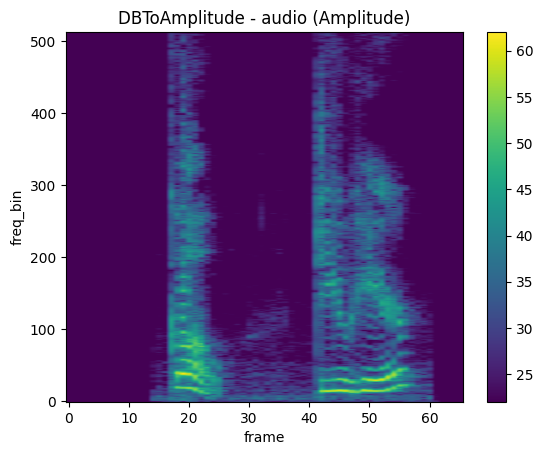

In [4]:
db_to_amplitude = audio.DBToAmplitude(0.5, 0.5)
spec_recovered = db_to_amplitude(db_specgram)
plot_spectrogram(spec_recovered, title="DBToAmplitude - audio (Amplitude)")

## AllpassBiquad

[mindspore.dataset.audio.AllpassBiquad](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.AllpassBiquad.html#mindspore.dataset.audio.AllpassBiquad) applies a two-pole all-pass filter to an audio waveform for audio signal transformation.


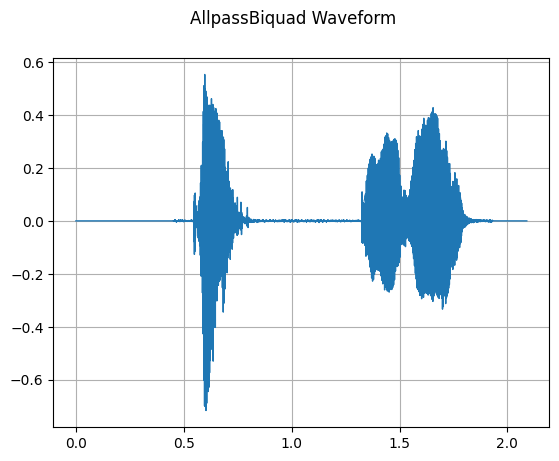

In [5]:
waveform = waveform.astype(np.float32)
waveform /= np.iinfo(np.int16).max
allpass_biquad = audio.AllpassBiquad(sample_rate=sample_rate, central_freq=200.0)
waveform_allpass = allpass_biquad(waveform)
plot_waveform(waveform_allpass, sample_rate, title="AllpassBiquad Waveform")
Audio(waveform_allpass, rate=sample_rate)

## Angle

[mindspore.dataset.audio.Angle](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Angle.html#mindspore.dataset.audio.Angle) computes the angle of a complex tensor input.


(33440, 2)


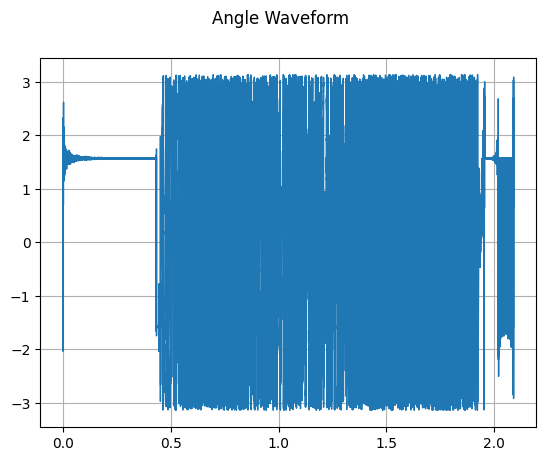

In [6]:
# Apply the Hilbert transform to get the analytic signal (complex)
analytic_signal = signal.hilbert(waveform)

# Create a complex waveform by stacking real and imaginary parts
complex_waveform = np.stack((analytic_signal.real, analytic_signal.imag), axis=-1)
print(complex_waveform.shape)

angle = audio.Angle()
transformed_waveform = angle(complex_waveform)
plot_waveform(transformed_waveform, sample_rate, title="Angle Waveform")
Audio(transformed_waveform, rate=sample_rate)

## BandBiquad

[mindspore.dataset.audio.BandBiquad](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.BandBiquad.html#mindspore.dataset.audio.BandBiquad) performs a biquad filter operation on the input audio signal. The frequency response rolls off logarithmically around the center frequency, and the bandwidth parameter controls the slope of this roll-off. This operation is similar to the [SoX](https://sourceforge.net/projects/sox/) implementation.


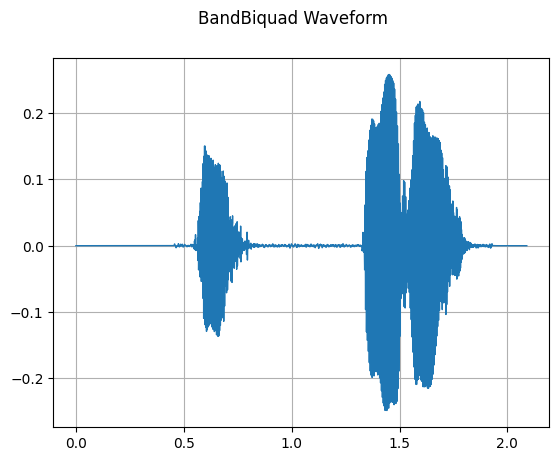

In [7]:
band_biquad = audio.BandBiquad(sample_rate=sample_rate, central_freq=200.0)
transformed_waveform = band_biquad(waveform)
plot_waveform(transformed_waveform, sample_rate, title="BandBiquad Waveform")
Audio(transformed_waveform, rate=sample_rate)

## BandpassBiqaud

[mindspore.dataset.audio.BandpassBiquad](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.BandpassBiquad.html#mindspore.dataset.audio.BandpassBiquad) performs a two-pole Butterworth Band-Pass Filter on the input audio signal.


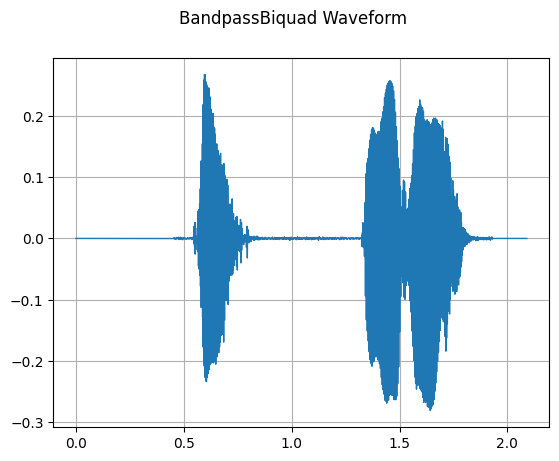

In [8]:
band_pass_biquad = audio.BandpassBiquad(sample_rate, 200.0)
transformed_waveform = band_pass_biquad(waveform)
plot_waveform(transformed_waveform, sample_rate, title="BandpassBiquad Waveform")
Audio(transformed_waveform, rate=sample_rate)

## BassBiquad

[mindspore.dataset.audio.BassBiquad](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.BassBiquad.html#mindspore.dataset.audio.BassBiquad) performs a two-pole low-shelf filter on the input audio signal.


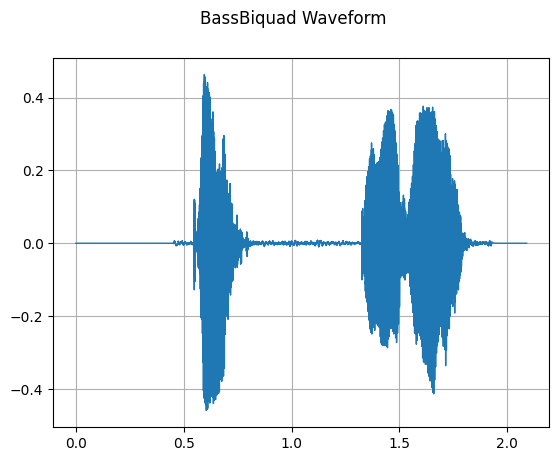

In [9]:
transforms = [
    audio.BassBiquad(sample_rate, 10.0),
]

for transform in transforms:
    transformed_waveform = transform(waveform)
    plot_waveform(transformed_waveform, sample_rate, title=transform.__class__.__name__ + " Waveform")
Audio(transformed_waveform, rate=sample_rate)

## Biquad

[mindspore.dataset.audio.Biquad](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Biquad.html#mindspore.dataset.audio.Biquad) performs a biquad filter operation on the input audio signal.


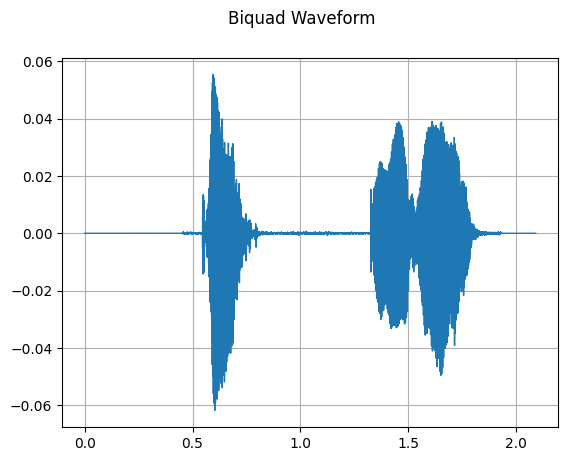

In [10]:
transform = audio.Biquad(0.01, 0.02, 0.13, 1, 0.12, 0.3)
transformed_waveform = transform(waveform)
plot_waveform(transformed_waveform, sample_rate, title="Biquad Waveform")
Audio(transformed_waveform, rate=sample_rate)

## Contrast

[mindspore.dataset.audio.Contrast](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Contrast.html#mindspore.dataset.audio.Contrast) is an audio transformation operation that applies a contrast effect to an audio waveform. Similar to compression, it makes the audio sound louder and more impactful by enhancing the contrast of the audio.


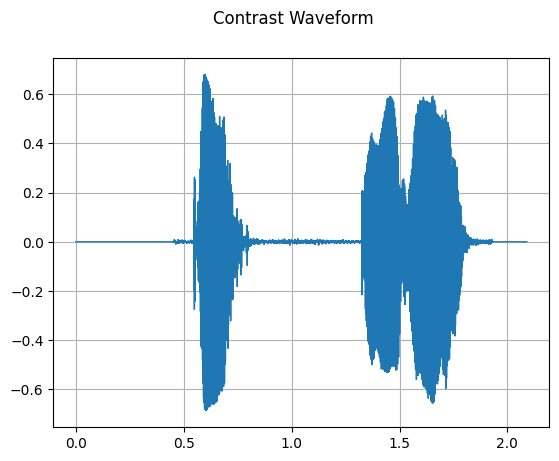

In [11]:
contrast_transform = audio.Contrast(enhancement_amount=85.0)
transformed_waveform = contrast_transform(waveform)
plot_waveform(transformed_waveform, sample_rate, title="Contrast Waveform")
Audio(transformed_waveform, rate=sample_rate)

## ComplexNorm

[mindspore.dataset.audio.ComplexNorm](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.ComplexNorm.html#mindspore.dataset.audio.ComplexNorm) computes the norm of a complex tensor input.


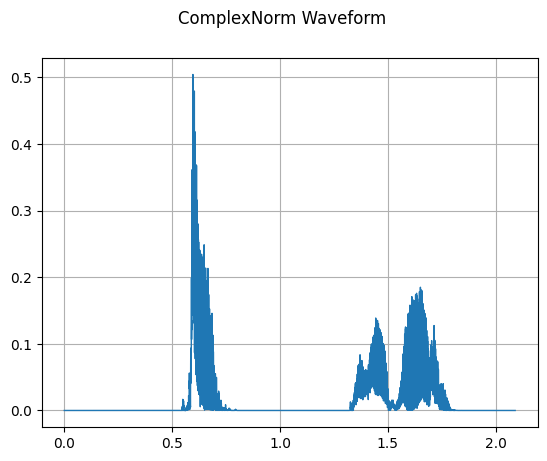

In [12]:
import scipy.signal as signal

# Apply the Hilbert transform to get the analytic signal (complex)
analytic_signal = signal.hilbert(waveform)

# Create a complex waveform by stacking real and imaginary parts
complex_waveform = np.stack((analytic_signal.real, analytic_signal.imag), axis=-1)

complex_norm = audio.ComplexNorm(power=2.0)
complex_norm_transformed = complex_norm(complex_waveform)
plot_waveform(complex_norm_transformed, sample_rate, title="ComplexNorm Waveform")
Audio(complex_norm_transformed, rate=sample_rate)

## ComputeDeltas

[mindspore.dataset.audio.ComputeDeltas](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.ComputeDeltas.html#mindspore.dataset.audio.ComputeDeltas) computes delta coefficients of an audio tensor.


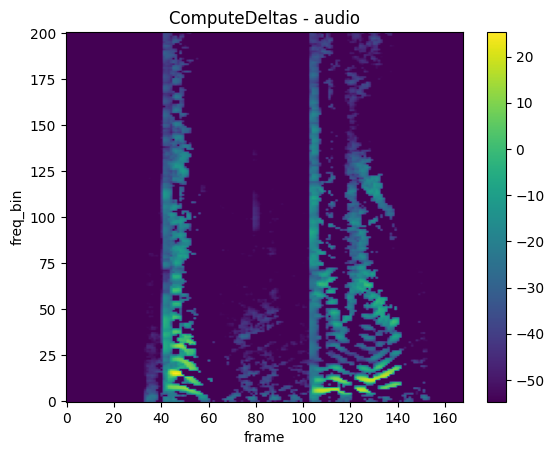

In [13]:
# Convert waveform to spectrogram
spectrogram = audio.Spectrogram()
spec = spectrogram(waveform)

# Apply ComputeDeltas transform
compute_deltas_transform = audio.ComputeDeltas(win_length=7, pad_mode=audio.BorderType.EDGE)
transformed_spectrogram = compute_deltas_transform(spec)
transformed_spectrogram = np.squeeze(transformed_spectrogram)
plot_spectrogram(transformed_spectrogram, title="ComputeDeltas - audio")

## DCShift

[mindspore.dataset.audio.DCShift](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.DCShift.html#mindspore.dataset.audio.DCShift) applies a DC shift to the input audio waveform. It is possible to remove DC offset from the audio.


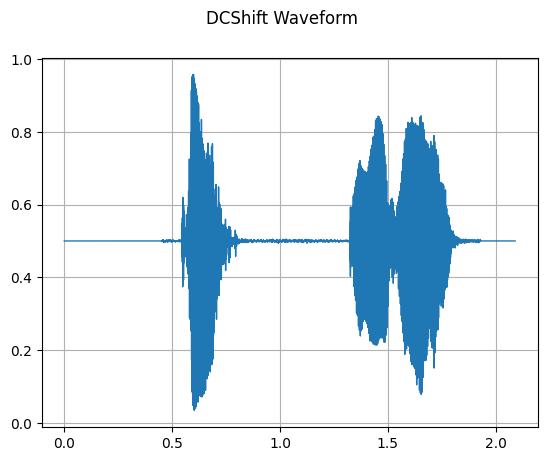

In [14]:
dc_shift = audio.DCShift(0.5, 0.02)
waveform_dc_shift = dc_shift(waveform)
plot_waveform(waveform_dc_shift, sample_rate, title="DCShift Waveform")
Audio(waveform_dc_shift, rate=sample_rate)

## DeemphBiquad

[mindspore.dataset.audio.DeemphBiquad](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.DeemphBiquad.html#mindspore.dataset.audio.DeemphBiquad) applies a Compact Disc (IEC 60908) de-emphasis (a high-frequency reduction shelving filter) effect to the audio waveform.


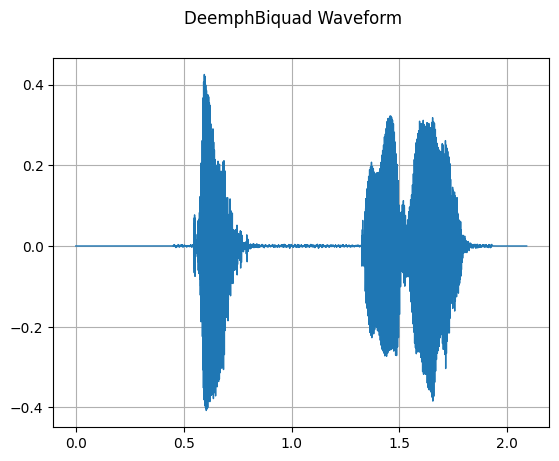

In [15]:
deemph_biquad = audio.DeemphBiquad(44100)
waveform_deemph_biquad = deemph_biquad(waveform)
plot_waveform(waveform_deemph_biquad, sample_rate, title="DeemphBiquad Waveform")
Audio(waveform_deemph_biquad, rate=sample_rate)

## DetectPitchFrequency

[mindspore.dataset.audio.DetectPitchFrequency](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.DetectPitchFrequency.html#mindspore.dataset.audio.DetectPitchFrequency) detects the pitch frequency of an audio waveform.


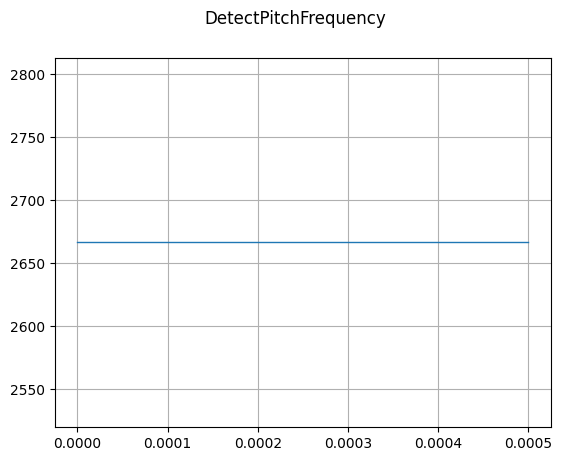

In [16]:
sample_rate, waveform = wavfile.read(wav_file)
waveform = waveform.astype(np.float32)
waveform /= np.iinfo(np.int16).max
detect = audio.DetectPitchFrequency(sample_rate=sample_rate, win_length=400)
pitch_freq = detect(waveform)
plot_waveform(pitch_freq, sample_rate, title="DetectPitchFrequency")

## Dither

[mindspore.dataset.audio.Dither](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Dither.html#mindspore.dataset.audio.Dither) is used to enhance the perceived dynamic range of audio at a specific bit depth, with the goal of eliminating nonlinear truncation distortion. By introducing quantization noise into the audio signal, the quality of the audio can be improved.


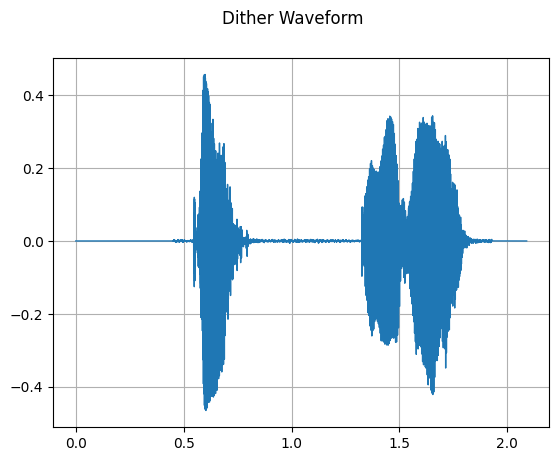

In [17]:
dither = audio.Dither()
waveform_dither = dither(waveform)
plot_waveform(waveform_dither, sample_rate, title="Dither Waveform")
Audio(waveform_dither, rate=sample_rate)

## EqualizerBiquad

[mindspore.dataset.audio.EqualizerBiquad](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.EqualizerBiquad.html#mindspore.dataset.audio.EqualizerBiquad) performs a two-pole equalizer filter on the input audio signal.


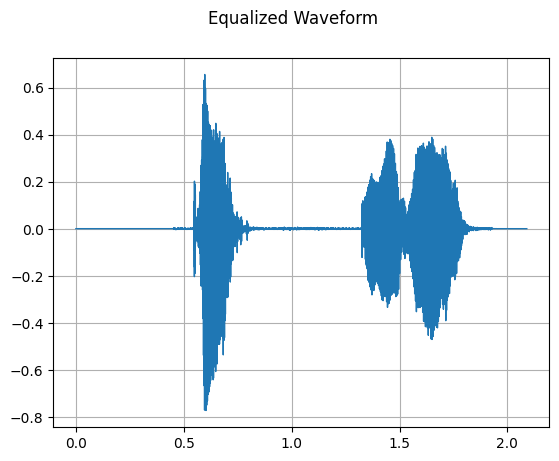

In [18]:
equalizer = audio.EqualizerBiquad(
    sample_rate=sample_rate,
    center_freq=1500,
    gain=5.5,
    Q=0.7
)

equalized_waveform = equalizer(waveform)
plot_waveform(equalized_waveform, sample_rate, title='Equalized Waveform')
Audio(equalized_waveform, rate=sample_rate)

## Fade

[mindspore.dataset.audio.Fade](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Fade.html#mindspore.dataset.audio.Fade) applies a fade in and fade out effect to the input audio.


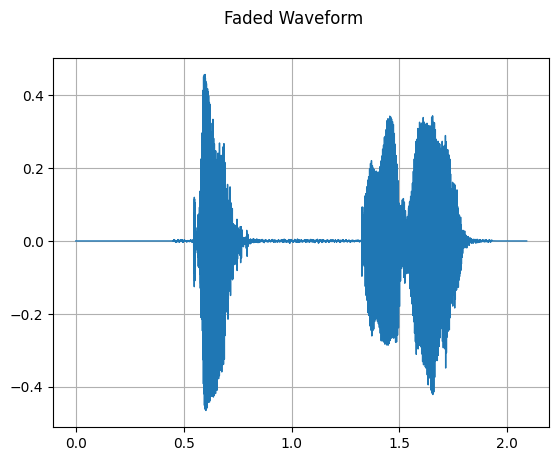

In [19]:
fade = audio.Fade(fade_in_len=4000, fade_out_len=4000, fade_shape=audio.FadeShape.LINEAR)
faded_waveform = fade(waveform)
plot_waveform(faded_waveform, sample_rate, title='Faded Waveform')
Audio(faded_waveform, rate=sample_rate)

## Filtfilt

[mindspore.dataset.audio.Filtfilt](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Filtfilt.html#mindspore.dataset.audio.Filtfilt) applies forward and reverse IIR filtering to an audio waveform.


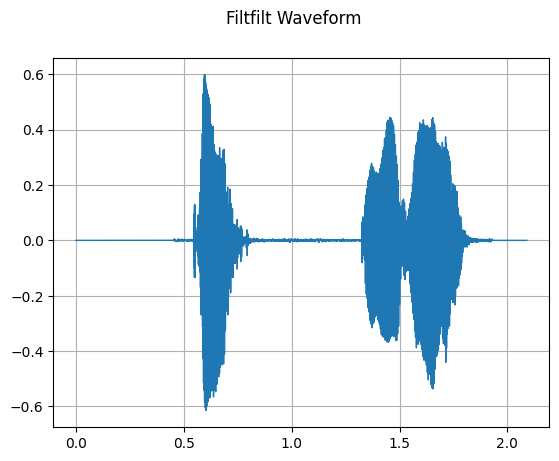

In [20]:
filtfilt = audio.Filtfilt(a_coeffs=[1.0, 0.1, 0.3], b_coeffs=[1.0, 0.1, 0.5])
filtfilt_waveform = filtfilt(waveform)
plot_waveform(filtfilt_waveform, sample_rate, title='Filtfilt Waveform')
Audio(filtfilt_waveform, rate=sample_rate)

## Flanger

[mindspore.dataset.audio.Flanger](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Flanger.html#mindspore.dataset.audio.Flanger) applies a Flanger effect to an audio waveform.


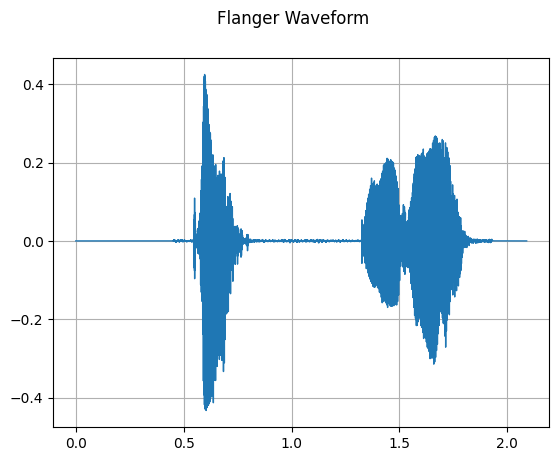

In [21]:
reshape_waveform = waveform[np.newaxis, :]
flanger = audio.Flanger(sample_rate=sample_rate)
flanger_waveform = flanger(reshape_waveform)
plot_waveform(flanger_waveform, sample_rate, 'Flanger Waveform')
Audio(flanger_waveform, rate=sample_rate)

## Gain

[mindspore.dataset.audio.Gain](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Gain.html#mindspore.dataset.audio.Gain) can adjust the gain of the audio waveform.


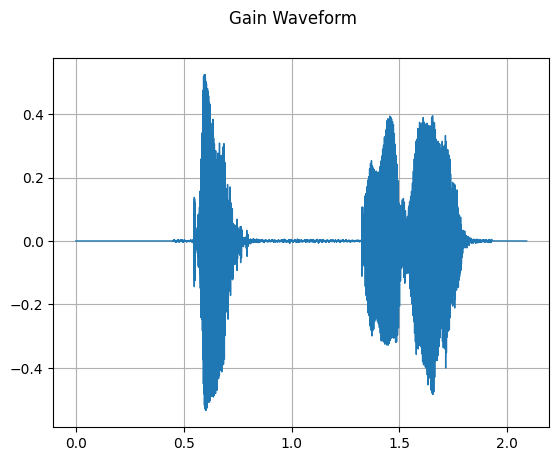

In [22]:
gain_transform = audio.Gain(1.2)
gain_waveform = gain_transform(waveform)
plot_waveform(gain_waveform, sample_rate, title="Gain Waveform")
Audio(gain_waveform, rate=sample_rate)

## HighpassBiquad

[mindspore.dataset.audio.HighpassBiquad](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.HighpassBiquad.html#mindspore.dataset.audio.HighpassBiquad) performs a two-pole Butterworth High-Pass Filter on the input audio signal.


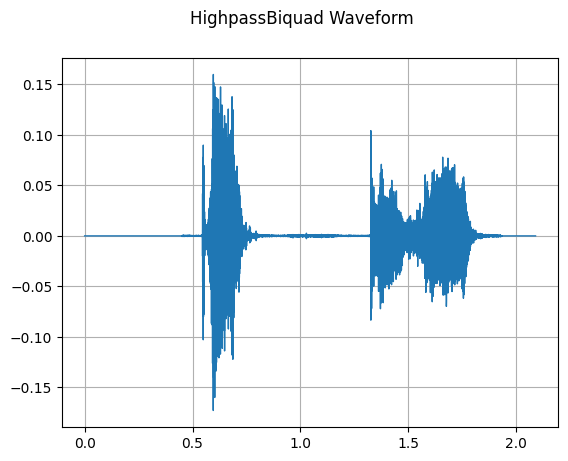

In [23]:
highpass_transform = audio.HighpassBiquad(sample_rate, 1500, 0.7)
highpass_waveform = highpass_transform(waveform)
plot_waveform(highpass_waveform, sample_rate, title="HighpassBiquad Waveform")
Audio(highpass_waveform, rate=sample_rate)

## LowpassBiquad

[mindspore.dataset.audio.LowpassBiquad](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.LowpassBiquad.html#mindspore.dataset.audio.LowpassBiquad) performs a two-pole Butterworth Low-Pass Filter on the input audio signal.


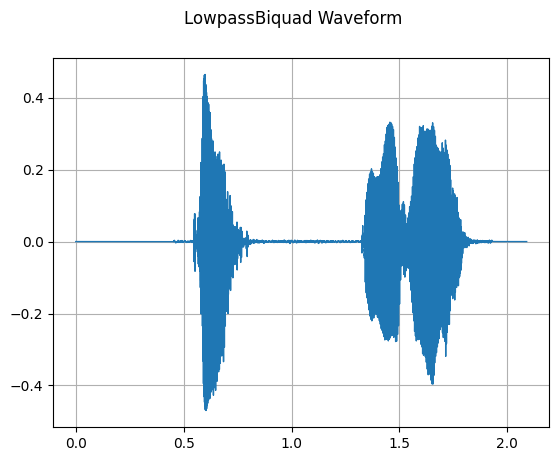

In [24]:
lowpass_biquad = audio.LowpassBiquad(sample_rate, 1500, 0.7)
lowpass_waveform = lowpass_biquad(waveform)
plot_waveform(lowpass_waveform, sample_rate, title="LowpassBiquad Waveform")
Audio(lowpass_waveform, rate=sample_rate)

## LFilter

[mindspore.dataset.audio.LFilter](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.LFilter.html#mindspore.dataset.audio.LFilter) applies a IIR filtering to an audio waveform.


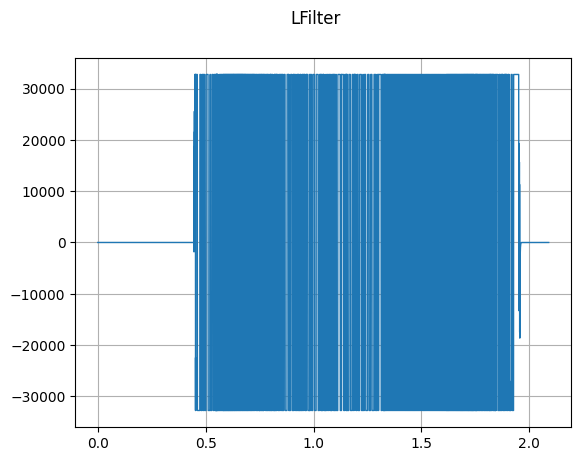

In [25]:
sample_rate, waveform = wavfile.read(wav_file)
waveform_f = waveform.astype(np.float32)
lfilter = audio.LFilter(a_coeffs=[1.0, -0.95], b_coeffs=[0.3, -0.2])
lfilter_transform = lfilter(waveform_f)

# Normalize or clip values to int16 range if needed
lfilter_transform = np.clip(lfilter_transform, -1.0, 1.0)
lfilter_transform = (lfilter_transform * 32767).astype(np.int16)

sample_rate = 16000
plot_waveform(lfilter_transform, sample_rate, title="LFilter")
lfilter_transform_audio = lfilter_transform.astype(np.float32) / 32767
Audio(lfilter_transform_audio, rate=sample_rate)

## Magphase

[mindspore.dataset.audio.Magphase](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Magphase.html#mindspore.dataset.audio.Magphase) separates a complex-valued tensor into its magnitude and phase.


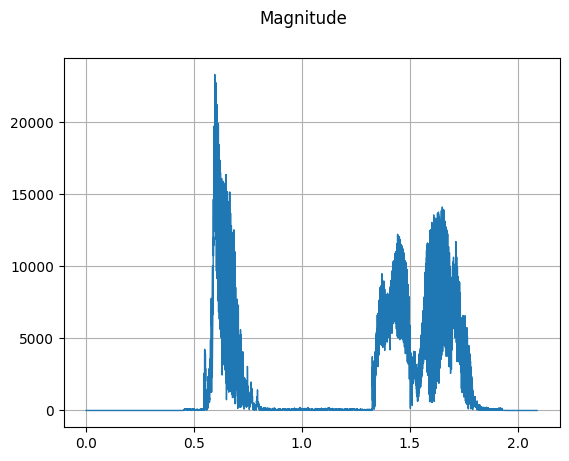

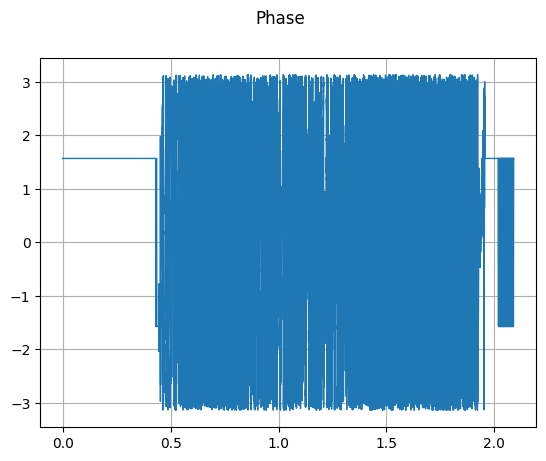

In [26]:
# Apply the Hilbert transform to get the analytic signal (complex)
analytic_signal = signal.hilbert(waveform)

# Create a complex waveform by stacking real and imaginary parts
complex_waveform = np.stack((analytic_signal.real, analytic_signal.imag), axis=-1)

magphase = audio.Magphase()
magnitude, phase = magphase(complex_waveform)
plot_waveform(magnitude, sample_rate, title="Magnitude")
plot_waveform(phase, sample_rate, title="Phase")

## MuLawEncoding

[mindspore.dataset.audio.MuLawEncoding](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.MuLawEncoding.html#mindspore.dataset.audio.MuLawEncoding) can encode audio waveforms into mu-law format.


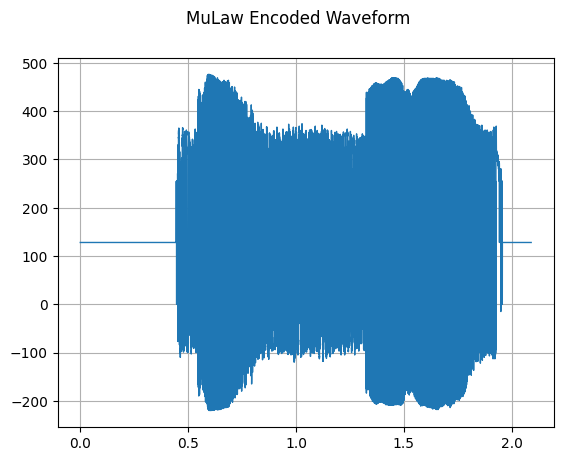

In [27]:
mulaw_encoding = audio.MuLawEncoding(quantization_channels=256)
encoded = mulaw_encoding(waveform)
plot_waveform(encoded, sample_rate, title="MuLaw Encoded Waveform")
Audio(encoded, rate=sample_rate)

## MuLawDecoding

[mindspore.dataset.audio.MuLawDecoding](https://www.mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.MuLawDecoding.html#mindspore.dataset.audio.MuLawDecoding) can decode mu-law encoded waveforms to raw audio waveforms. Refer to [mu-law algorithm](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm).


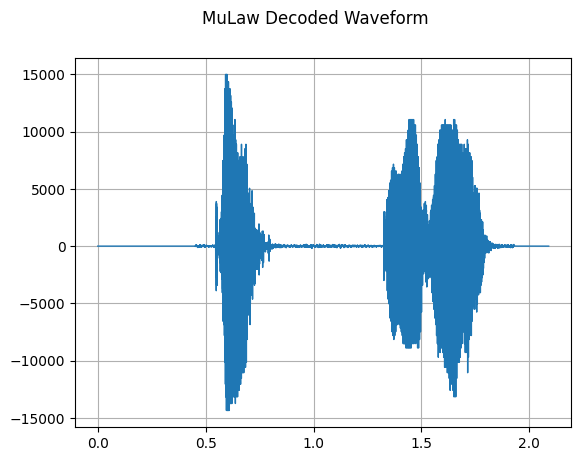

In [28]:
mulaw_decode = audio.MuLawDecoding(quantization_channels=256)
decode = mulaw_decode(encoded)
plot_waveform(decode, sample_rate, title="MuLaw Decoded Waveform")
Audio(decode, rate=sample_rate)

## Spectrogram

[mindspore.dataset.audio.Spectrogram](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Spectrogram.html#mindspore.dataset.audio.Spectrogram) creates a spectrogram from an audio signal.


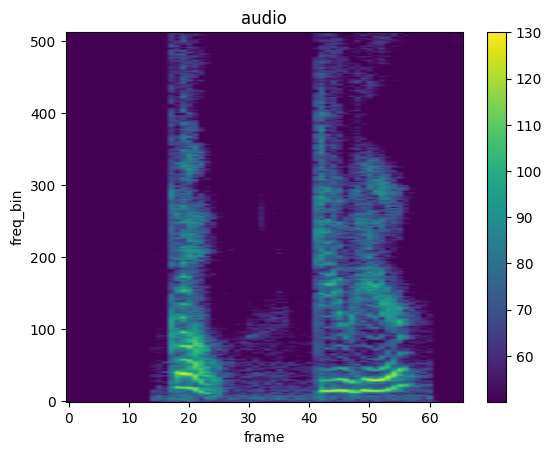

In [29]:
sample_rate, waveform = wavfile.read(wav_file)

# Perform transform
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = audio.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode=audio.BorderType.REFLECT,
    power=2.0,
)

spec = spectrogram(waveform)
plot_spectrogram(spec, title="audio")

## InverseSpectrogram

[mindspore.dataset.audio.InverseSpectrogram](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.InverseSpectrogram.html#mindspore.dataset.audio.InverseSpectrogram) inverts a spectrogram back to a waveform.


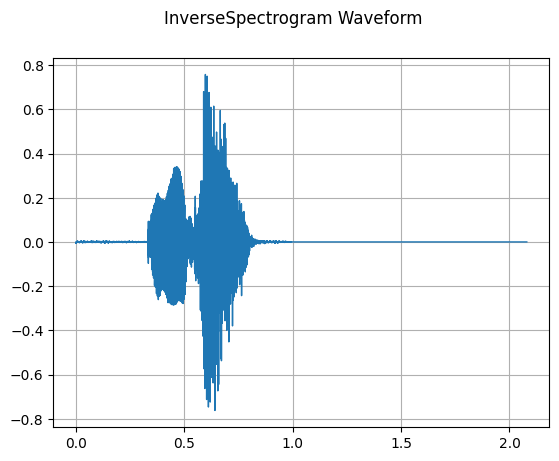

In [30]:
wav_file = "84-121123-0000.wav"
y, sr = librosa.load(wav_file, sr=None)

n_fft = 2048
hop_length = 512

s = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
s_real = np.real(s)
s_imag = np.imag(s)
s_complex = np.stack((s_real, s_imag), axis=-1)

inverse_spectrogram = audio.InverseSpectrogram(n_fft=n_fft, hop_length=hop_length)
reconstructed = inverse_spectrogram(s_complex)

# Compute magnitude spectrogram of the reconstructed signal
reconstructed_s = librosa.stft(reconstructed, n_fft=n_fft, hop_length=hop_length)
reconstructed_magnitude = np.abs(reconstructed_s)
plot_waveform(reconstructed, sr, title='InverseSpectrogram Waveform')
Audio(reconstructed, rate=sr)

## GriffinLim

[mindspore.dataset.audio.GriffinLim](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.GriffinLim.html#mindspore.dataset.audio.GriffinLim) recovers a waveform from a spectrogram.


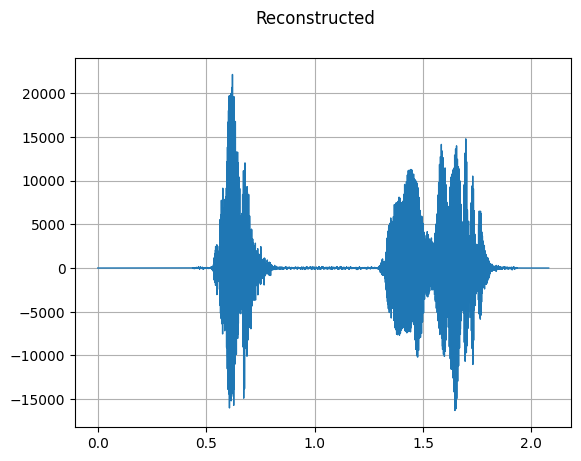

In [31]:
n_fft = 1024
win_length = None
hop_length = 512

spec = audio.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(waveform)

griffin_lim = audio.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

reconstructed_waveform = griffin_lim(spec)

plot_waveform(reconstructed_waveform, sample_rate, title="Reconstructed")
Audio(reconstructed_waveform, rate=sample_rate)

## Mel Filter Bank

[mindspore.dataset.audio.melscale_fbanks](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.melscale_fbanks.html#mindspore.dataset.audio.melscale_fbanks) generates frequency transformation matrix.


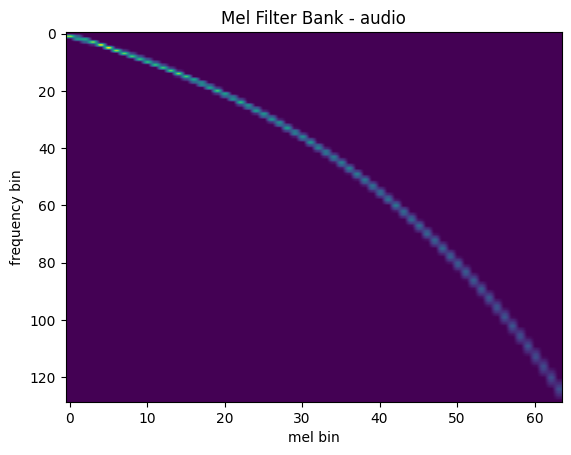

In [32]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = audio.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm=audio.NormType.SLANEY,
)

plot_fbank(mel_filters, "Mel Filter Bank - audio")

## MelSpectrogram

[mindspore.dataset.audio.MelSpectrogram](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.MelSpectrogram.html#mindspore.dataset.audio.MelSpectrogram) creates a mel-scale spectrogram for a raw audio signal.


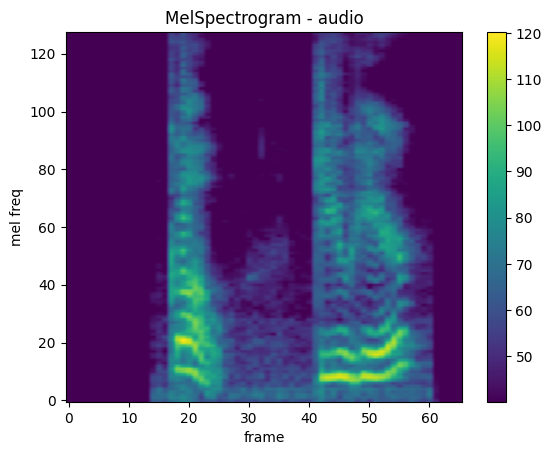

In [33]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = audio.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode=audio.BorderType.REFLECT,
    power=2.0,
    norm=audio.NormType.SLANEY,
    onesided=True,
    n_mels=n_mels,
    mel_scale=audio.MelType.HTK,
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec, title="MelSpectrogram - audio", ylabel="mel freq")

## MelScale

[mindspore.dataset.audio.MelScale](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.MelScale.html#mindspore.dataset.audio.MelScale) converts a spectrogram to a mel spectrogram.


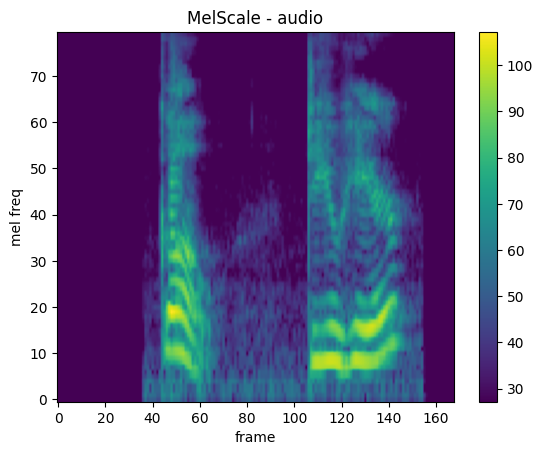

In [34]:
sample_rate, waveform = wavfile.read(wav_file)
spectrogram = audio.Spectrogram()
spec = spectrogram(waveform)
n_stft = spec.shape[-2]
n_mels = min(n_stft - 1, 80)

mel_scale = audio.MelScale(
    n_mels=n_mels,
    sample_rate=sample_rate,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    n_stft=n_stft,
    norm=audio.NormType.SLANEY,
    mel_type=audio.MelType.HTK,
)
mel_spec = mel_scale(spec)
plot_spectrogram(mel_spec, title="MelScale - audio", ylabel="mel freq")

## InverseMelScale

[mindspore.dataset.audio.InverseMelScale](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.InverseMelScale.html#mindspore.dataset.audio.InverseMelScale) converts the Mel-frequency STFT to a normal-frequency STFT.


(201, 168)


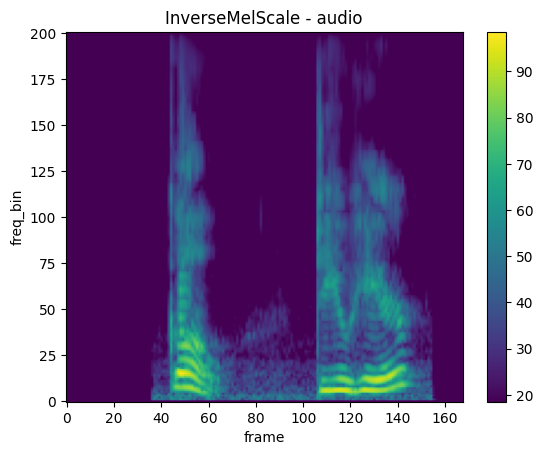

In [35]:
inverse_mel_scale = audio.InverseMelScale(
    n_stft=n_stft,
    n_mels=n_mels,
    sample_rate=sample_rate,
    f_min=0.0,
    f_max=None,
    max_iter=10000,
    tolerance_loss=1e-05,
    tolerance_change=1e-08,
    sgdargs=None,
    norm=audio.NormType.SLANEY,
    mel_type=audio.MelType.HTK
)
inverse_mel = inverse_mel_scale(mel_spec)
inverse_mel = inverse_mel.squeeze(0)
print(inverse_mel.shape)
plot_spectrogram(inverse_mel, title="InverseMelScale - audio")

## MFCC

[mindspore.dataset.audio.MFCC](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.MFCC.html#mindspore.dataset.audio.MFCC) calculates Mel Frequency Cepstrum Coefficient for a raw audio signal.


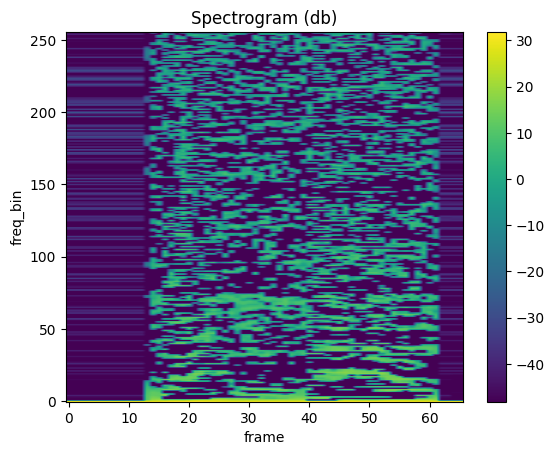

In [36]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = audio.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "win_length": n_fft,
        "f_min": 0.0,
        "f_max": sample_rate // 2,
        "pad": 0,
        "pad_mode": audio.BorderType.REFLECT,
        "power": 2.0,
        "n_mels": n_mels,
        "normalized": False,
        "center": True,
        "onesided": True,
        "window": audio.WindowType.HANN,
        "hop_length": hop_length,
        "norm": audio.NormType.NONE,
        "mel_scale": audio.MelType.HTK,
    },
)

mfcc = mfcc_transform(waveform)
mfcc = np.squeeze(mfcc)
plot_spectrogram(mfcc)

## LFCC

[mindspore.dataset.audio.LFCC](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.LFCC.html#mindspore.dataset.audio.LFCC) calculates Linear Frequency Cepstral Coefficient for a raw audio signal.


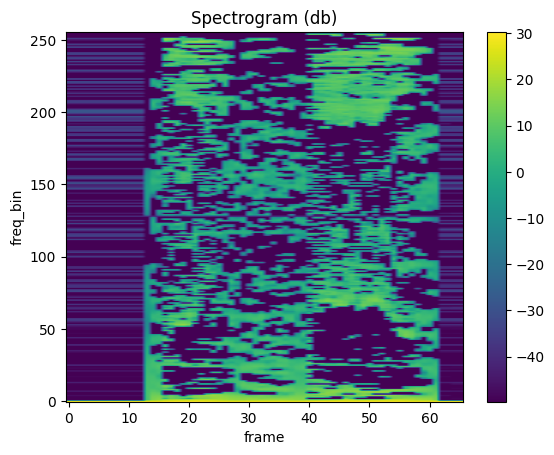

In [37]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = audio.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": n_fft,
        "hop_length": hop_length,
        "pad": 0,
        "window": audio.WindowType.HANN,
        "power": 2.0,
        "normalized": False,
        "center": True,
        "pad_mode": audio.BorderType.REFLECT,
        "onesided": True
    },
)

lfcc = lfcc_transform(waveform)
plot_spectrogram(lfcc)

## SpectralCentroid

[mindspore.dataset.audio.SpectralCentroid](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.SpectralCentroid.html#mindspore.dataset.audio.SpectralCentroid) calculates the spectral centroid of a waveform.


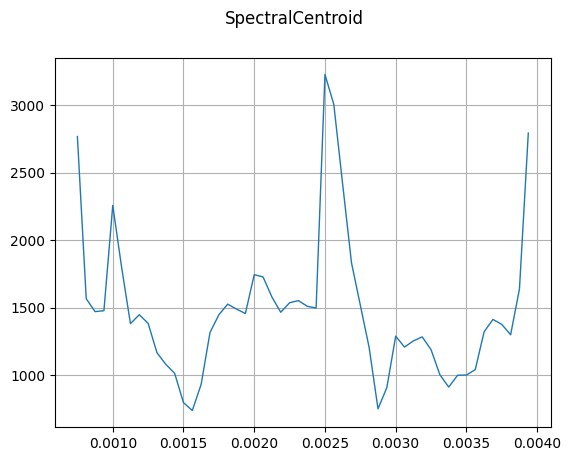

In [38]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256
sample_rate, waveform = wavfile.read(wav_file)

spcetral_centroid = audio.SpectralCentroid(sample_rate=sample_rate, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
centroid = spcetral_centroid(waveform)
plot_waveform(centroid, sample_rate, title="SpectralCentroid")

## TimeMasking

[mindspore.dataset.audio.TimeMasking](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.TimeMasking.html#mindspore.dataset.audio.TimeMasking) applies time masking to the audio signal.


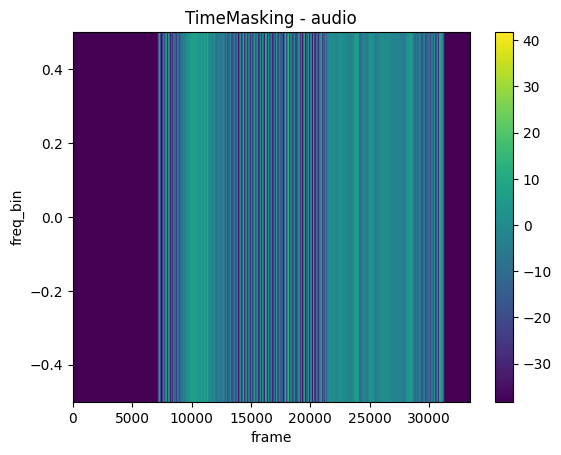

In [39]:
if waveform.ndim == 1:
    waveform = waveform[np.newaxis, :]
time_masking = audio.TimeMasking(time_mask_param=1)
time_masked = time_masking(waveform)
plot_spectrogram(time_masked, title="TimeMasking - audio")

## TimeStretch

[mindspore.dataset.audio.TimeStretch](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.TimeStretch.html#mindspore.dataset.audio.TimeStretch) applies time stretch to the audio signal.


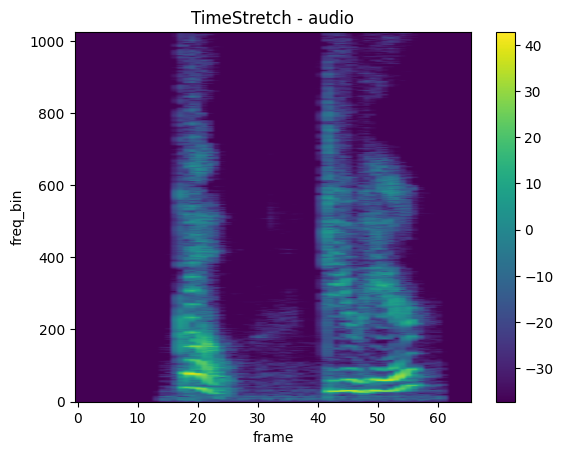

In [40]:
wav_file = "84-121123-0000.wav"
y, sr = librosa.load(wav_file, sr=None)

# Parameters for STFT
n_fft = 2048
hop_length = 512
s = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

# Separate real and imaginary parts
s_real = np.real(s)
s_imag = np.imag(s)

# Stack real and imaginary parts
s_complex = np.stack((s_real, s_imag), axis=-1)

# Apply time stretch
time_stretch = audio.TimeStretch()
stretched = time_stretch(s_complex)

# Convert complex result to magnitude
s_stretched_real = stretched[..., 0]
s_stretched_imag = stretched[..., 1]
s_stretched = s_stretched_real + 1j * s_stretched_imag
stretch = np.squeeze(s_stretched)
stretch = np.abs(stretch)**2
plot_spectrogram(stretch, title='TimeStretch - audio')

## Overdrive

[mindspore.dataset.audio.Overdrive](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Overdrive.html#mindspore.dataset.audio.Overdrive) applies an overdrive effect to the audio signal.


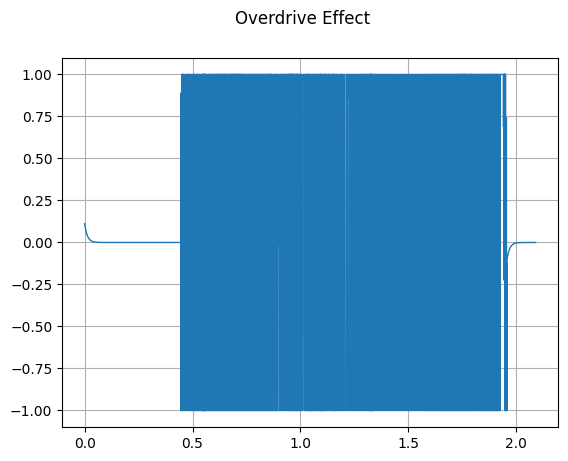

In [41]:
overdrive = audio.Overdrive(gain=30.0, color=30.0)
waveform_overdrive = overdrive(waveform)
plot_waveform(waveform_overdrive, sample_rate, title="Overdrive Effect")
Audio(waveform_overdrive, rate=sample_rate)

## Phaser

[mindspore.dataset.audio.Phaser](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Phaser.html#mindspore.dataset.audio.Phaser) applies a phaser effect to the audio signal.


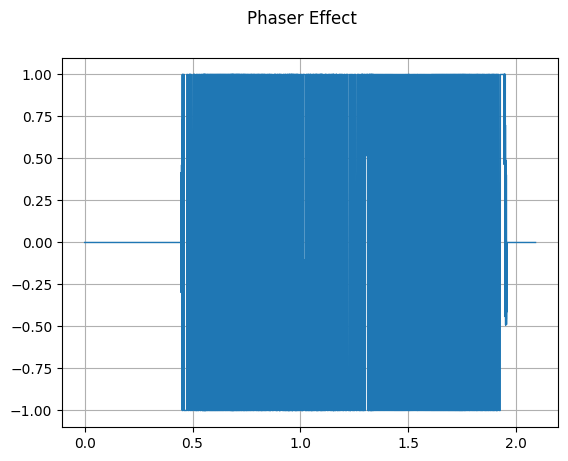

In [42]:
phaser = audio.Phaser(
    sample_rate=sample_rate,
    gain_in=0.4,
    gain_out=0.74,
    delay_ms=3.0,
    decay=0.4,
    mod_speed=0.5,
    sinusoidal=True
)

waveform_phaser = phaser(waveform)
plot_waveform(waveform_phaser, sample_rate, title="Phaser Effect")
Audio(waveform_phaser, rate=sample_rate)

## PitchShift

[mindspore.dataset.audio.PitchShift](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.PitchShift.html#mindspore.dataset.audio.PitchShift) applies pitch shift to the audio signal.


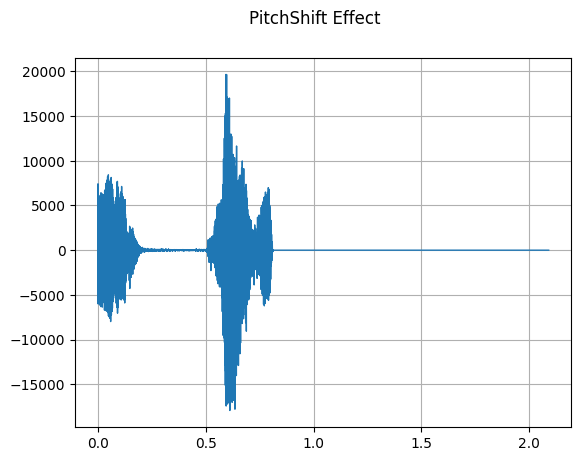

In [43]:
pitch_shift = audio.PitchShift(sample_rate=sample_rate, n_steps=4)
waveform_pitch_shift = pitch_shift(waveform)
plot_waveform(waveform_pitch_shift, sample_rate, title="PitchShift Effect")
Audio(waveform_pitch_shift, rate=sample_rate)

## Resample

[mindspore.dataset.audio.Resample](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Resample.html#mindspore.dataset.audio.Resample) resamples the audio signal to a different sample rate.


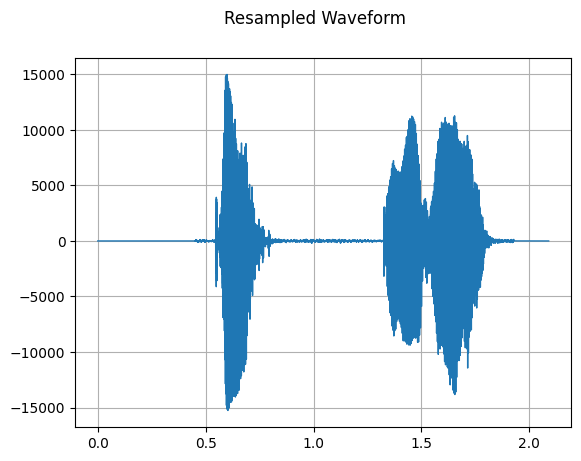

In [44]:
resample_transform = audio.Resample(orig_freq=sample_rate, new_freq=16000)
resampled_waveform = resample_transform(waveform)
plot_waveform(resampled_waveform, sample_rate, title="Resampled Waveform")
Audio(resampled_waveform, rate=sample_rate)

## RiaaBiquad

[mindspore.dataset.audio.RiaaBiquad](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.RiaaBiquad.html#mindspore.dataset.audio.RiaaBiquad) applies RIAA filtering to the audio signal.


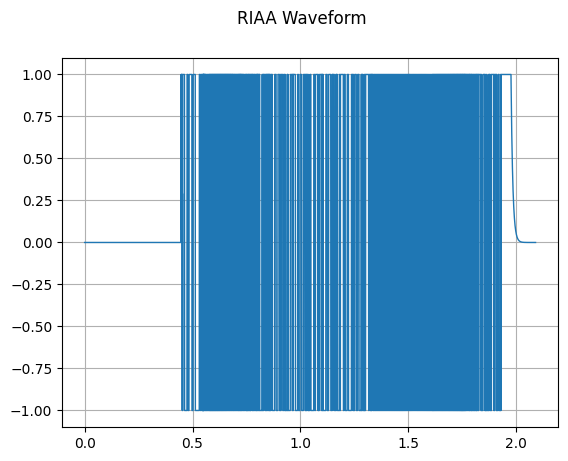

In [45]:
waveform = waveform.astype(np.float32)
riaa_transform = audio.RiaaBiquad(sample_rate=44100)
riaa_waveform = riaa_transform(waveform)
plot_waveform(riaa_waveform, sample_rate, title="RIAA Waveform")
Audio(riaa_waveform, rate=sample_rate)

## SlidingWindowCmn

[mindspore.dataset.audio.SlidingWindowCmn](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.SlidingWindowCmn.html#mindspore.dataset.audio.SlidingWindowCmn) applies sliding window cepstral mean normalization to the audio signal.


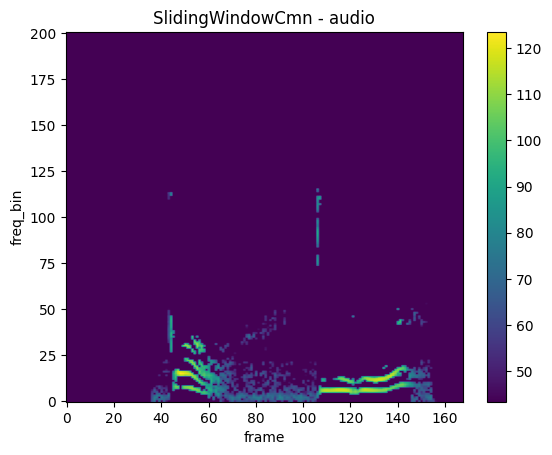

In [46]:
sample_rate, waveform = wavfile.read(wav_file)
waveform = waveform.astype(np.float32)
spectrogram = audio.Spectrogram()
spec = spectrogram(waveform)
sliding_window_cmn = audio.SlidingWindowCmn()
waveform_cmn = sliding_window_cmn(spec)
plot_spectrogram(waveform_cmn, title="SlidingWindowCmn - audio")

## FrequencyMasking

[mindspore.dataset.audio.FrequencyMasking](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.FrequencyMasking.html#mindspore.dataset.audio.FrequencyMasking) applies frequency masking to the audio signal.


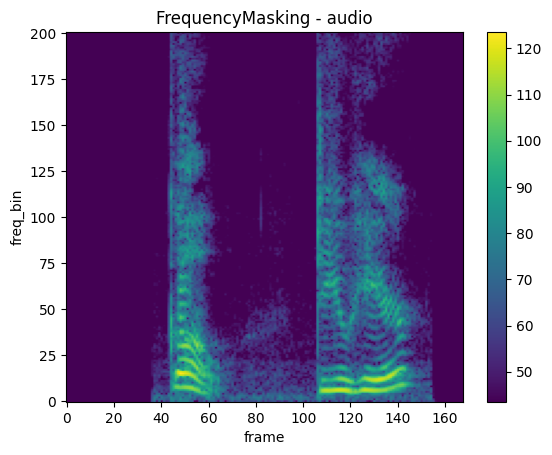

In [47]:
spectrogram = audio.Spectrogram()
spec = spectrogram(waveform)
frequency_masking = audio.FrequencyMasking()
frequency_masked = frequency_masking(spec)
plot_spectrogram(frequency_masked, title="FrequencyMasking - audio")

## Vad

[mindspore.dataset.audio.Vad](https://mindspore.cn/docs/en/master/api_python/dataset_audio/mindspore.dataset.audio.Vad.html#mindspore.dataset.audio.Vad) applies voice activity detection to the audio signal.


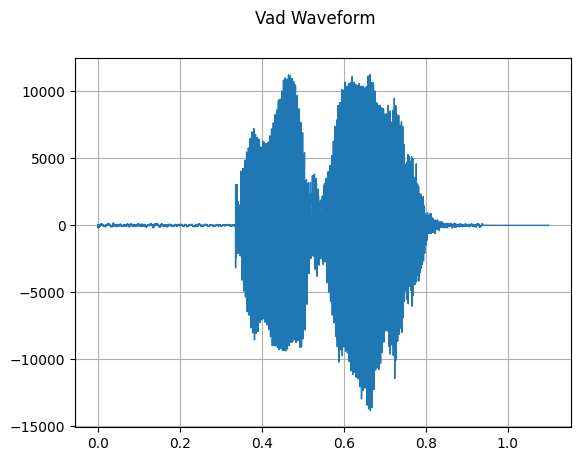

In [48]:
vad_transform = audio.Vad(sample_rate=sample_rate)
vad_waveform = vad_transform(waveform)
plot_waveform(vad_waveform, sample_rate, title='Vad Waveform')
Audio(vad_waveform, rate=sample_rate)

## Process Wav File In Dataset Pipeline

Use the [mindspore.dataset.GeneratorDataset](https://mindspore.cn/docs/en/master/api_python/dataset/mindspore.dataset.GeneratorDataset.html#mindspore.dataset.GeneratorDataset) to read wav files into dataset pipeline and then we can do further transforms based on pipeline.


number of samples in dataset: 3
>>>>> after gain


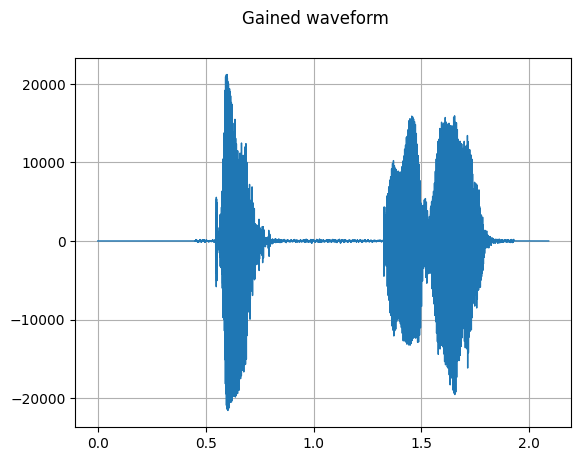

In [49]:
import scipy.io.wavfile as wavfile
import mindspore.dataset as ds
import mindspore.dataset.audio as audio

# Define dataloader
class DataLoader():
    def __init__(self):
        self.sample_rate, self.wave = wavfile.read("84-121123-0000.wav")
    def __next__(self):
        return next(self.data)
    def __iter__(self):
        self.data = iter([(self.wave, self.sample_rate), (self.wave, self.sample_rate), (self.wave, self.sample_rate)])
        return self

# Load 3 waveforms into dataset pipeline
dataset = ds.GeneratorDataset(DataLoader(), column_names=["wav", "sample_rate"], shuffle=False)

# check the sample numbers in dataset
print("number of samples in dataset:", dataset.get_dataset_size())

# apply gain on "wav" column
dataset = dataset.map(audio.Gain(gain_db=3.0), input_columns=["wav"])

# check results, specify the output type to NumPy for drawing
print(">>>>> after gain")
for waveform, sample_rate  in dataset.create_tuple_iterator(output_numpy=True):
    # show the wav
    plot_waveform(waveform, sample_rate, title="Gained waveform")
    # after drawing one wav, break
    break